In our DRAF we pose the problem:

$$ \min_{\beta} ||\bar{B}\beta -x ||_{2}^2$$
$$\text{s.t} \beta_i^{||.||} \leq \gamma w_{l_i}$$

To apply R-RF we need a lasso problem (that is, the restriction should be $ || \beta_i^{||.||} ||_1 \leq c$), for the moment, we will pose a relaxation of the problem:

$$ \min_{\beta} ||\bar{B}\beta -x ||_{2}^2$$
$$\text{s.t} \sum_{i} \beta_i^{||.||} \leq \gamma \sum_{i}w_{l_i}$$

note that $\sum_{i} \beta_i^{||.||} = ||\beta^{||.||}||_1$, as all the components of $\beta_i^{||.||}$ are positive. Sin embargo tenemos un problema en el planteamiento del problema de minimos cuadrados, especilamente en la restricción.

En el DRAFT definimos:

$$\beta^{||.||} = \begin{bmatrix}
           ||\lambda_1||_{2} \\
           ||\lambda_2||_{2} \\
           \vdots \\
           ||\lambda_3||_{2}
         \end{bmatrix}$$

Sin embargo para poder trabjar con lasso debemos tener restricciones en terminos de la norma $1$, es decir debemos trabajar con el vector:

$$\beta^{||.||}_1 = \begin{bmatrix}
           ||\lambda_1||_{1} \\
           ||\lambda_2||_{1} \\
           \vdots \\
           ||\lambda_3||_{1}
        \end{bmatrix}$$

Note que $\frac{1}{p}||\lambda_i||_{1} < ||\lambda_i||_{2}  \leq \gamma w_{l_i}$ y de esta forma: $\frac{1}{p} \sum_{i}||\lambda_i||_{1} = \frac{1}{p} ||\beta||_1 = ||\beta||_< \gamma \sum_{i}w_{l_i}$. Entonces neustro problema reformulado es:


$$ \min_{\beta} ||\bar{B}\beta -x ||_{2}^2$$
$$\text{s.t} \sum_{i} \beta_{1,i}^{||.||} = ||\beta^{||.||}_1||_1 = ||\beta||_1 \leq p\gamma \sum_{i}w_{l_i}$$

Pasaremos entonces a implementar R-FS en nuestro problema jugete:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [3]:
X_or = np.array([
    [1,1],
    [1,2],
    [2,1],
    [2,2]
])

X_ref = -X_or

X = np.vstack((X_or, X_ref))

Pesos:

In [4]:
def knn_w(X, k=3, phi=0.5):

    D = cdist(X,X, 'euclidean')
    np.fill_diagonal(D, np.inf)

    n = D.shape[0]
    W = np.zeros((n,n))

    for i in range(n): #Recorremos cada punto
        idx = np.argsort(D[i,:]) #Indices de los k vecinos más cercanos
        for j in idx[0:k]:  # skip the first one since it's the point itself
            W[i,j] = np.exp(-phi * D[i,j])

    W = np.maximum(W, W.T)  # Hacer la matriz simétrica
    
    return W

In [5]:
W_knn = knn_w(X, k=3, phi=0.25)

In [6]:
def plot_graph_weights(X, W, title):
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(X[:,0], X[:,1], c='steelblue', s=80, zorder=3)
    
    nonzero_W = W[W > 0]
    vmin, vmax = np.min(nonzero_W), np.max(nonzero_W)
    
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if W[i,j] > 0:
                plt.plot(
                    [X[i,0], X[j,0]],
                    [X[i,1], X[j,1]],
                    color=plt.cm.plasma((W[i,j]-vmin)/(vmax-vmin)),
                    linewidth=2.5 * (W[i,j]/vmax),
                    alpha=0.9
                )
    
    # Etiquetas de nodos
    for i, (x, y) in enumerate(X):
        plt.text(x+0.05, y+0.05, f"{i}", fontsize=11, color="black")

    sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm, ax = ax)
    cbar.set_label('Edge Weights', rotation=270, labelpad=15)

    ax.set_title(title)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.show()


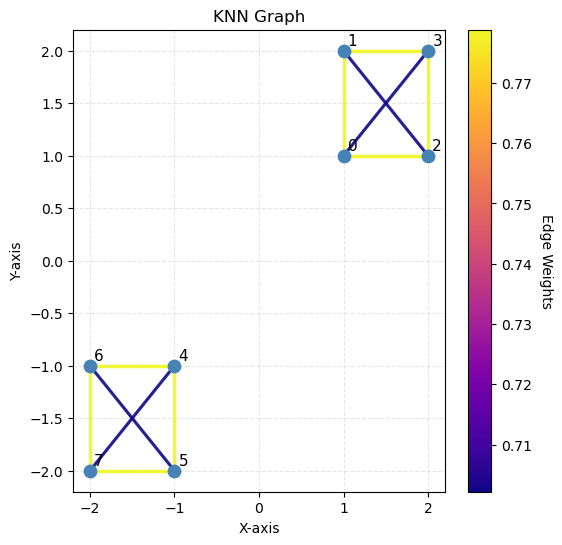

In [7]:
plot_graph_weights(X, W_knn, "KNN Graph")

Ahora para llegar a nuestro problema debemos tener: La matriz $\bar{B}$, la constante $p\gamma \sum_{i}w_{l_i}$ y el vector de los datos $x$



$$\bold{p \gamma \sum_i w_{l_i}}$$

In [8]:
def lassoconstant(W,gamma =1, p=2):
    """
    Lasso constant for the relaxation problem.
    Parameters:
    ----------
    W : np.ndarray
        Weight matrix. 
    gamma : float
        Regularization parameter.
    p : int
        Dimensionality of the data.
    Returns:
    -------
    float
        Lasso constant.
    """
    return p * gamma * np.sum(W)

$$\bar{B}$$

In [9]:
import networkx as nx

def built_edges(W):
    """
    Build edges and weights from the weight matrix W.
    Parameters:
        W: Weight matrix.
    Returns:  
        edges: List of edges.
    """
    n = W.shape[0] 
    edges = []
    for i in range(n):
        for j in range(i+1, n):
            if W[i,j] > 0:
                edges.append((i,j))

    return edges

def BigB(W, n):
    """
    Build incidence matrix from edges.
    Parameters:
        W: Weight matrix.
        n: Dimention of the data.
    Returns:
        B: Incidence matrix.
    """
    edges = built_edges(W)
    G = nx.Graph()
    G.add_edges_from(edges)
    B = -nx.incidence_matrix(G, oriented=True, dtype= float).toarray()
    barB = np.kron(B, np.eye(n))
    return barB, edges

In [10]:
barB = BigB(W_knn, 2)[0]

$$\bold{x}$$

In [11]:
def vop(X):
    return X.flatten()

__Lasso Solution__

We know use the formulation of our problem, first we do lasso with ```scikit-learn```

In [12]:
import cvxpy as cp

def beta_lasso(W, X, dim, gamma):
    """"
    Solve the lasso problem to find beta.
    Parameters:
        W_knn: Weight matrix.
        X: Data matrix.
        dim: Dimention of the data.
        gamma: Regularization parameter.
    Returns:
        beta: Solution of the lasso problem.
        value: Optimal value of the objective function.
    """   
    
    edges = built_edges(W)
    
    barB = BigB(W, dim)[0]

    beta = cp.Variable(len(edges)*dim)

    constraints = [cp.norm1(beta) <= lassoconstant(W, gamma=gamma, p=dim)]

    objective = cp.Minimize(cp.norm2(barB @ beta - vop(X))**2)
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return beta.value, prob.value


Tenemos entonces la siguiente función que se puede entender como un pipeline

In [13]:
def centers(W, X, dim=2, gamma=0.5, visualize=True):

    """
    Encontrar los centros usando la relajación dual + lasso.
    Parámetros:
        W -- matriz de pesos
        X -- puntos originales
        dim -- dimensión de los puntos (por defecto 2)
        gamma -- parámetro de regularización para lasso (por defecto 0.5)
        visualize -- si es True, se grafican los centros encontrados (por defecto True)
    Salida:
        centers -- lista de tuplas representando los centros encontrados    
    """
    beta = beta_lasso(W, X, dim=dim, gamma=gamma)[0]
    barB, _ = BigB(W, dim)
    deltas = barB @ beta
    centersvect =vop(X) - deltas

    centers = []
    for i in range(0,len(centersvect),2):
        centers.append(tuple(centersvect[i:i+2]))
    
    if visualize:
        x = [p[0] for p in centers]
        y = [p[1] for p in centers]
        x_points = [p[0] for p in X]
        y_points = [p[1] for p in X]

        plt.figure(figsize=(10, 8))
        plt.scatter(x, y, color='red', s=100, alpha=0.7, label='Centers')
        plt.scatter(x_points, y_points, color='blue', s=80, alpha=0.5, label='Original Points')
        plt.title('Centers found via dual + lasso relaxation')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        plt.legend()
        plt.axis('equal') 
        plt.show()

    return centers

## Lasso

### 4 points

#### 3-knn

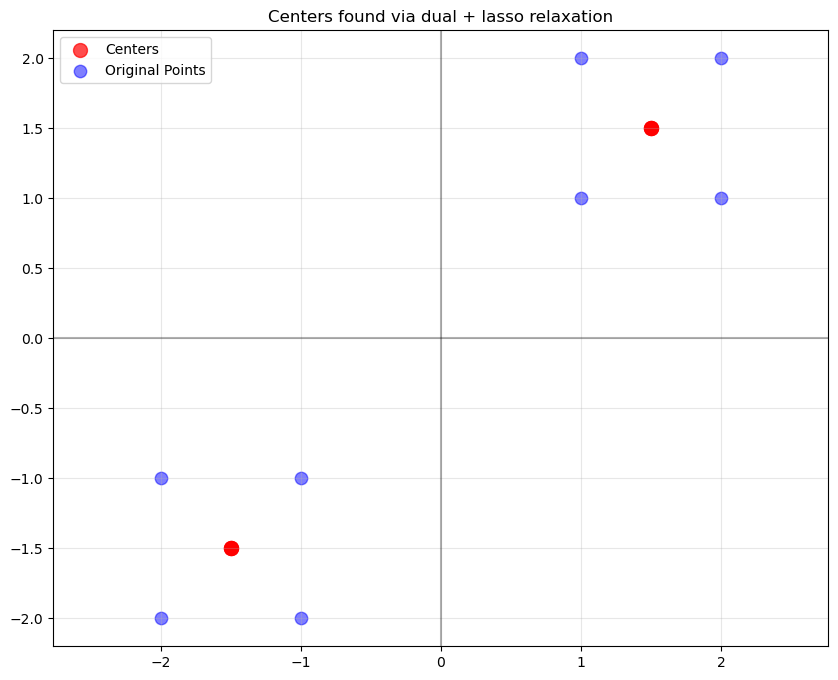

Centers found: [(1.500000903634598, 1.5000009036345967), (1.500000903634598, 1.4999990963654015), (1.4999990963654022, 1.5000009036345985), (1.4999990963654017, 1.4999990963654033), (-1.500000903634599, -1.5000009036345978), (-1.500000903634599, -1.4999990963654022), (-1.4999990963654013, -1.500000903634598), (-1.4999990963654009, -1.499999096365402)]


In [14]:
W = knn_w(X, k=3, phi=0.25)
centers_found = centers(W, X, dim=2, gamma=0.5, visualize=True)
print("Centers found:", centers_found)

Podemos incluso trazar el camino que hacen los centros:

In [64]:
def plot_cluster_path(W, X, dim=2, max_gamma=5, num_points=10000):
    """
    Plot the cluster path for varying gamma values.
    Parameters:
        W -- weight matrix
        X -- original points
        dim -- dimension of the points (default 2)
        max_gamma -- maximum gamma value (default 5)
        num_points -- number of gamma values to evaluate (default 10000)
    Returns:
        None
    """

    gamma = np.linspace(0, max_gamma, num_points)
    centers_path = []

    for ind,g in enumerate(gamma):
        if ind == 0:
            print("Starting cluster path computation...")
        if ind == len(gamma)-1:
            print("Completed cluster path computation.")
        elif ind % (len(gamma)//10) == 0:
            print(f"Completed cluster path at: {ind/len(gamma)*100} %")
        centers_g = centers(W, X, dim=dim, gamma=g, visualize=False)
        centers_path.append(centers_g)
        
    plt.figure(figsize=(10, 8))
    print("Plotting cluster path...")
    for i, centers_g in enumerate(centers_path):
        x = [p[0] for p in centers_g]
        y = [p[1] for p in centers_g]
        plt.scatter(x, y, s=4, alpha=1, marker = "_", color = "0")

    x_points_data = [p[0] for p in X]
    y_points_data = [p[1] for p in X]
    plt.scatter(x_points_data, y_points_data, color='blue', s=80, alpha=0.5, label='Original Points')
    plt.legend()
    plt.title('Cluster Path via dual + lasso relaxation')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.axis('equal')
    plt.show()

In [ ]:
plot_cluster_path(W_knn, X, dim=2, max_gamma=5, num_points=1000)

#### 4-knn

In [ ]:
W_knn_4 = knn_w(X, k=4, phi=0.25)
plot_cluster_path(W_knn_4, X, dim=2, max_gamma=5, num_points=1000)

#### Fully conected

In [39]:
def fully_connected_w(X):

    D = cdist(X,X, 'euclidean')
    D = np.maximum(D, 1e-10)
    W = 1 / np.square(D)
    W = np.minimum(W, 1e10)
    np.fill_diagonal(W, 0)
    
    return W

In [ ]:
W_full = fully_connected_w(X)
plot_cluster_path(W_full, X, dim=2, max_gamma=5, num_points=1000)

### Non symetrical points

#### 10 random points 3 clusters

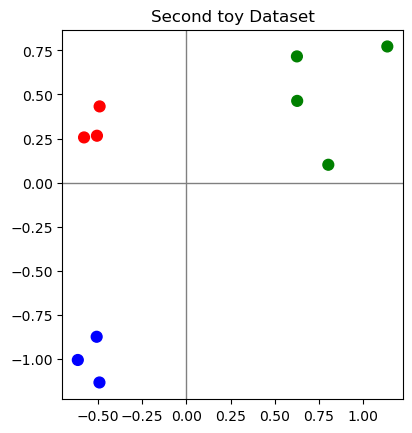

In [65]:
np.random.seed(42)

C1 = np.random.normal(loc=[-0.5, 0.2], scale=0.1, size=(3, 2))

C2 = np.random.normal(loc=[0.8, 0.5], scale=0.25, size=(4, 2))

C3 = np.random.normal(loc=[-0.3, -1.0], scale=0.15, size=(3, 2))

Y = np.vstack([C1, C2, C3])

Y -= Y.mean(axis=0)

plt.scatter(Y[:, 0], Y[:, 1], c=['r']*3 + ['g']*4 + ['b']*3, s=60)
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.gca().set_aspect('equal')
plt.title("Second toy Dataset")
plt.show()

##### 3-knn 

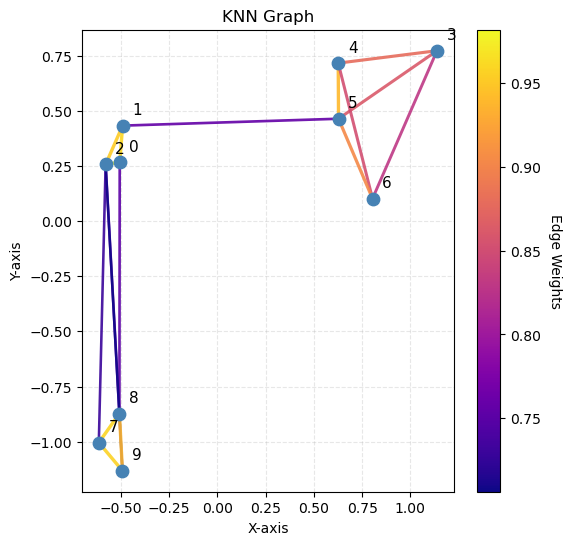

In [74]:
w_knn_Y_3 = knn_w(Y, k=3, phi=0.25)
plot_graph_weights(Y, w_knn_Y_3, "KNN Graph")

Starting cluster path computation...
Completed cluster path at: 0.0 %
Completed cluster path at: 10.0 %
Completed cluster path at: 20.0 %
Completed cluster path at: 30.0 %
Completed cluster path at: 40.0 %
Completed cluster path at: 50.0 %
Completed cluster path at: 60.0 %
Completed cluster path at: 70.0 %
Completed cluster path at: 80.0 %
Completed cluster path at: 90.0 %
Completed cluster path computation.
Plotting cluster path...


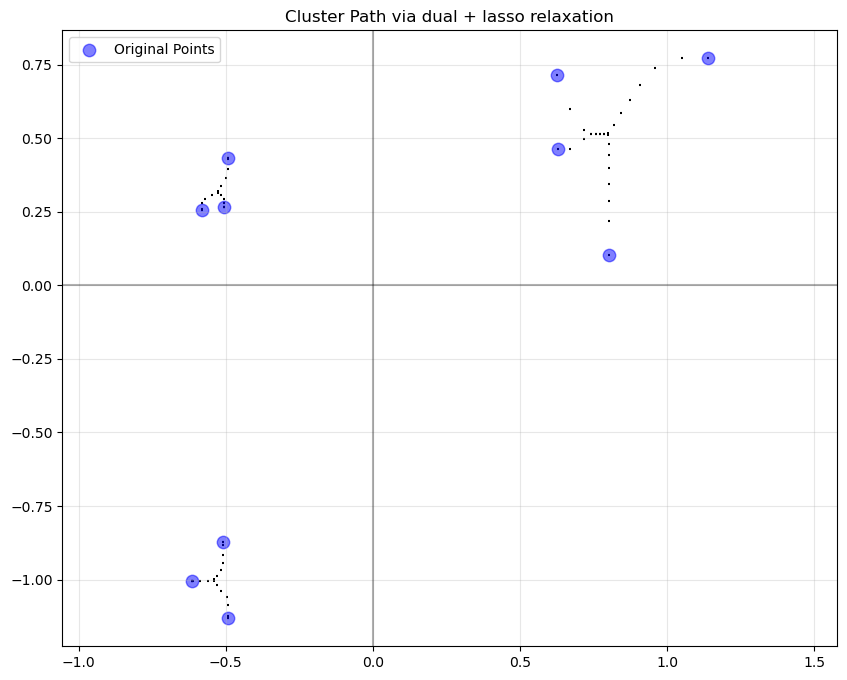

In [ ]:
plot_cluster_path(w_knn_Y_3, Y, dim=2, max_gamma=5, num_points=1000)

##### 5-knn

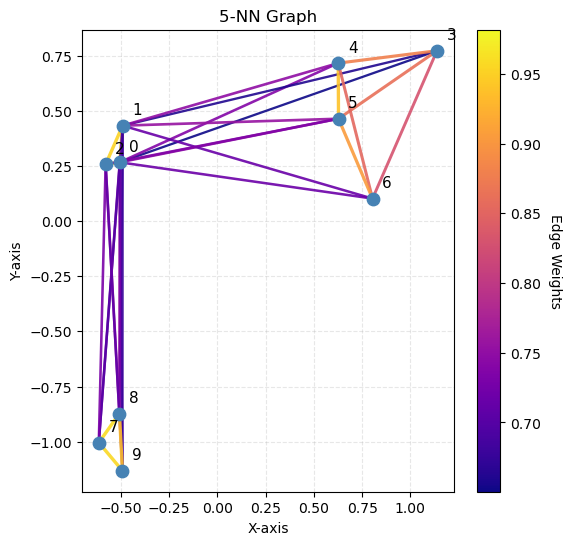

In [75]:
w_knn_Y_5 = knn_w(Y, k=5, phi=0.25)
plot_graph_weights(Y, w_knn_Y_5, "5-NN Graph")

Starting cluster path computation...
Completed cluster path at: 0.0 %
Completed cluster path at: 10.0 %
Completed cluster path at: 20.0 %
Completed cluster path at: 30.0 %
Completed cluster path at: 40.0 %
Completed cluster path at: 50.0 %
Completed cluster path at: 60.0 %
Completed cluster path at: 70.0 %
Completed cluster path at: 80.0 %
Completed cluster path at: 90.0 %
Completed cluster path computation.
Plotting cluster path...


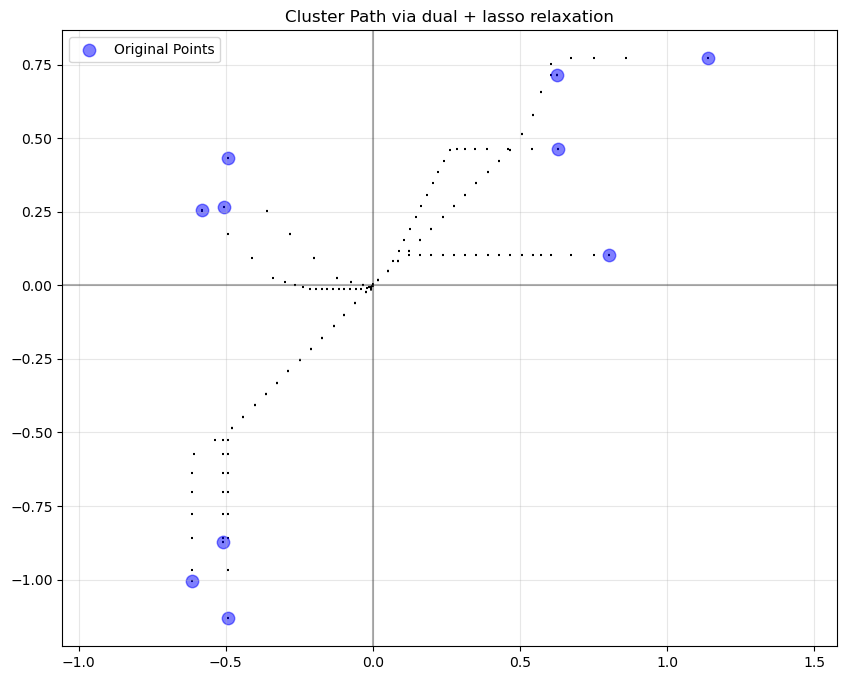

In [76]:
plot_cluster_path(w_knn_Y_5, Y, dim=2, max_gamma=5, num_points=1000)

##### fully connected

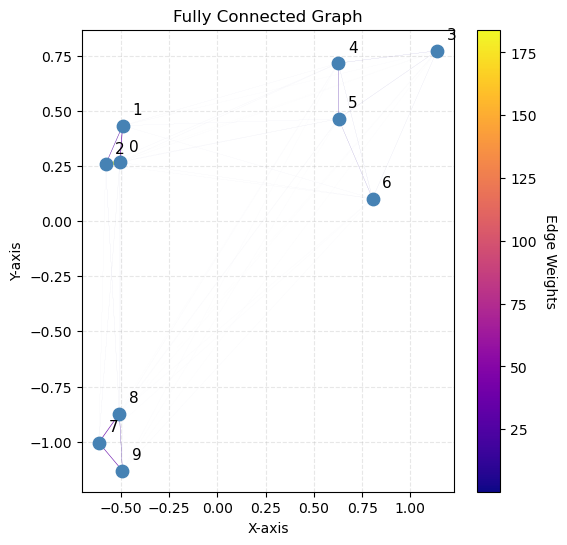

In [77]:
W_Y_full = fully_connected_w(Y)
plot_graph_weights(Y, W_Y_full, "Fully Connected Graph")

Starting cluster path computation...
Completed cluster path at: 0.0 %
Completed cluster path at: 10.0 %
Completed cluster path at: 20.0 %
Completed cluster path at: 30.0 %
Completed cluster path at: 40.0 %
Completed cluster path at: 50.0 %
Completed cluster path at: 60.0 %
Completed cluster path at: 70.0 %
Completed cluster path at: 80.0 %
Completed cluster path at: 90.0 %
Completed cluster path computation.
Plotting cluster path...


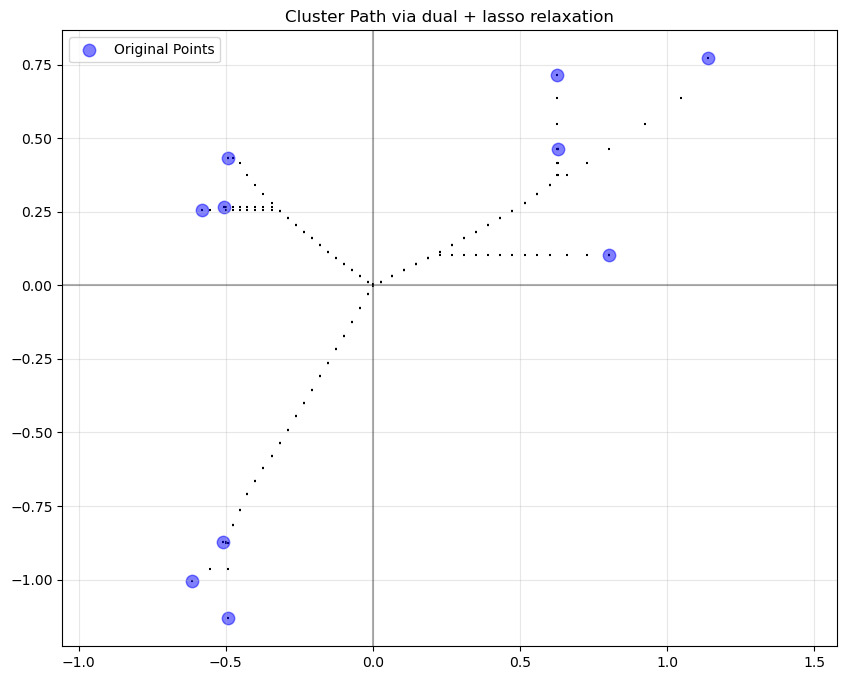

In [82]:
plot_cluster_path(W_Y_full, Y, dim=2, max_gamma=1, num_points=5000)